### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold

### Helper Feature Extraction Functions

In [2]:
def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    df = df.merge(pd.read_csv("all_times.csv"), how='inner').fillna(1)
    return df.drop(['spread'], axis=1).drop(['dom'], axis=1)
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def log_returns(waps):
    return -np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

### Generating Features for Stock X

In [3]:
def generate_features(file_path):
    
    df = pd.read_csv(file_path)
    
    # fill seconds
    df = df.groupby('time_id').apply(fill_seconds).reset_index(drop=True)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    # import pre-computed beta as feature for each stock
    #df['beta'] = df.groupby('stock_id').apply(import_beta)
    
    # target is volatility at t = 600 seconds i.e. over entire time bucket
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean],#, mad, np.max, np.sum],
        'wap2':[np.mean],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility],
        'log_returns2':[realized_volatility],
        'wap_diff':[np.mean],#, mad, np.max, np.sum],
        'price_diff':[np.mean],#, mad, np.max, np.sum],
        'price_diff2':[np.mean],#, mad, np.max, np.sum],
        'bid_diff':[np.mean],#, mad, np.max, np.sum],
        'ask_diff':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean],#, mad, np.max, np.sum],
        'dom':[np.mean],#, mad, np.max, np.sum],
        'dom_diff':[np.mean],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean],#, mad, np.max, np.sum],
        #'beta':[np.mean, mad, np.max, np.sum]
    }

    #####groupby / target realized volatility for entire window
    df_feature = pd.DataFrame(df.query(f'seconds_in_bucket >= {300}').groupby(['time_id']).agg(target_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col).rstrip('_') for col in df_feature.columns if len(col) > 1] 
    
    ######groupby / last XX seconds     # 0         300|         600
    last_seconds = [300, 150]
    
    for second in last_seconds:
    
        df_feature_sec = pd.DataFrame(
            df.query(f'{300-second} <= seconds_in_bucket < {300}')
              .groupby(['time_id']).agg(feature_dict)).reset_index()

        df_feature_sec.columns = ['_'.join(col).rstrip('_') for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        df_feature = pd.merge(df_feature, df_feature_sec, 
                              how='left', 
                              left_on='time_id', 
                              right_on=f'time_id_{second}')
        
        df_feature = df_feature.drop([f'time_id_{second}'],axis=1)
        
    #create stock_id
    df_feature['stock_id'] = int(file_path.split('/')[1].split('_')[1].split('.')[0])
    df_feature['time_id'] = df_feature['time_id'].apply(int)
    
    return df_feature

In [4]:
def concat_features(stock_id, df):
    file = "individual_book_train/stock_" + str(stock_id) + ".csv"        
    return pd.concat([df, generate_features(file)])

def process_stocks(list_stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(delayed(concat_features)(stock_id, df) for stock_id in list_stock_ids)
    
    # lastly import pre-computed beta coefficients for all stock_ids
    return import_beta(pd.concat(df, ignore_index = True))

In [5]:
list_stock_ids = [0, 1]
process_stocks(list_stock_ids)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.1s finished


,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns2_realized_volatility_300,wap_diff_mean_300,price_diff_mean_300,price_diff2_mean_300,bid_diff_mean_300,...,bid_ask_volume_mean_150,bid_ask_volume_diff_mean_150,dom_mean_150,dom_diff_mean_150,dom_imbalance_mean_150,bid_ask_spread1_mean_150,bid_ask_spread2_mean_150,bid_ask_spread3_mean_150,stock_id,beta
0,5,0.002954,1.003597,1.003512,0.003394,0.005032,0.000431,0.000898,0.001181,0.000150,...,385.893333,104.173333,387.473512,104.579531,282.893981,0.000924,0.001210,0.000287,0,1.208072
1,11,0.000981,0.999987,0.999983,0.000699,0.001448,0.000175,0.000501,0.000780,0.000124,...,287.446667,185.740000,287.427179,185.696666,101.730513,0.000349,0.000577,0.000228,0,1.719756
2,16,0.001295,0.999960,1.000110,0.001983,0.003583,0.000302,0.000728,0.001134,0.000235,...,416.440000,124.533333,416.324722,124.528371,291.796351,0.000649,0.001063,0.000414,0,7.164047
3,31,0.001776,0.999219,0.998835,0.001863,0.002422,0.000427,0.000901,0.001159,0.000151,...,474.473333,150.540000,473.912342,150.489650,323.422692,0.001104,0.001365,0.000260,0,6.559597
4,62,0.001520,0.999769,0.999684,0.001131,0.002412,0.000201,0.000365,0.000636,0.000184,...,289.800000,183.813333,289.691152,183.744996,105.946156,0.000326,0.000579,0.000253,0,0.680616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,32751,0.002212,1.000155,1.000018,0.002995,0.004029,0.000368,0.000589,0.000860,0.000142,...,256.986667,145.146667,257.018158,145.139117,111.879041,0.000570,0.000851,0.000281,1,0.225453
5404,32753,0.008499,1.003102,1.002956,0.006710,0.006974,0.000331,0.000763,0.001004,0.000121,...,643.240000,278.266667,648.157332,280.523088,367.634244,0.000797,0.001043,0.000248,1,28.996320
5405,32758,0.002108,1.000470,1.000498,0.002320,0.002842,0.000214,0.000676,0.000928,0.000136,...,358.753333,206.646667,358.906680,206.636831,152.269849,0.000618,0.000891,0.000273,1,1.602334
5406,32763,0.002728,1.001599,1.001610,0.002573,0.003696,0.000202,0.000429,0.000866,0.000216,...,545.080000,91.840000,546.592730,92.128979,454.463752,0.000477,0.000959,0.000483,1,3.980220


### Generate Train-Test Split

In [6]:
def train_test_split_ids(n = 7):
    stock_ids = pd.read_csv("all_times.csv").stock_id.unique()
    n = len(stock_ids)
    return stock_ids[0:7*(n//10)], stock_ids[7*(n//10):]

train_ids, test_ids = train_test_split_ids(7)
print(f"Train set size:\t{len(train_ids)}\nTest set size:\t{len(test_ids)}")

df_train = process_stocks(train_ids)
df_test = process_stocks(test_ids)

Train set size:	77
Test set size:	35


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.3min finished


In [7]:
from sklearn.model_selection import KFold

tmp_train = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 0)
for idx_1, idx_2 in kf.split(df_train):
    tmean = df_train.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
    tmp_train[idx_2] = df_train['stock_id'].iloc[idx_2].map(tmean)
    
tmp_test = np.repeat(np.nan, df_test.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 0)
for idx_1, idx_2 in kf.split(df_test):
    tmean = df_test.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
    tmp_test[idx_2] = df_test['stock_id'].iloc[idx_2].map(tmean)
    
df_train['target_mean_enc'] = tmp_train
df_test['target_mean_enc'] = tmp_test

In [8]:
df_train

,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns2_realized_volatility_300,wap_diff_mean_300,price_diff_mean_300,price_diff2_mean_300,bid_diff_mean_300,...,bid_ask_volume_diff_mean_150,dom_mean_150,dom_diff_mean_150,dom_imbalance_mean_150,bid_ask_spread1_mean_150,bid_ask_spread2_mean_150,bid_ask_spread3_mean_150,stock_id,beta,target_mean_enc
0,5,0.002954,1.003597,1.003512,0.003394,0.005032,0.000431,0.000898,0.001181,0.000150,...,104.173333,387.473512,104.579531,282.893981,0.000924,0.001210,0.000287,0,1.208072,0.002934
1,11,0.000981,0.999987,0.999983,0.000699,0.001448,0.000175,0.000501,0.000780,0.000124,...,185.740000,287.427179,185.696666,101.730513,0.000349,0.000577,0.000228,0,1.719756,0.002900
2,16,0.001295,0.999960,1.000110,0.001983,0.003583,0.000302,0.000728,0.001134,0.000235,...,124.533333,416.324722,124.528371,291.796351,0.000649,0.001063,0.000414,0,7.164047,0.002921
3,31,0.001776,0.999219,0.998835,0.001863,0.002422,0.000427,0.000901,0.001159,0.000151,...,150.540000,473.912342,150.489650,323.422692,0.001104,0.001365,0.000260,0,6.559597,0.002917
4,62,0.001520,0.999769,0.999684,0.001131,0.002412,0.000201,0.000365,0.000636,0.000184,...,183.813333,289.691152,183.744996,105.946156,0.000326,0.000579,0.000253,0,0.680616,0.002946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208203,32751,0.001781,0.997427,0.997413,0.002233,0.002719,0.000077,0.000230,0.000579,0.000175,...,326.673333,1499.383677,325.384073,1173.999603,0.000254,0.000605,0.000349,86,5.170807,0.001978
208204,32753,0.003012,0.998684,0.998789,0.001629,0.002433,0.000179,0.000344,0.000710,0.000167,...,519.140000,1667.191314,518.529501,1148.661813,0.000294,0.000660,0.000366,86,6.386436,0.001993
208205,32758,0.000976,1.000397,1.000271,0.001559,0.001930,0.000142,0.000286,0.000665,0.000191,...,246.626667,1406.320927,246.820684,1159.500244,0.000265,0.000648,0.000383,86,-0.599727,0.001978
208206,32763,0.001210,0.999923,0.999893,0.001252,0.001719,0.000085,0.000252,0.000755,0.000252,...,1620.640000,7393.377005,1621.234935,5772.142070,0.000252,0.000755,0.000503,86,1.638146,0.001990


In [9]:
df_test

,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns2_realized_volatility_300,wap_diff_mean_300,price_diff_mean_300,price_diff2_mean_300,bid_diff_mean_300,...,bid_ask_volume_diff_mean_150,dom_mean_150,dom_diff_mean_150,dom_imbalance_mean_150,bid_ask_spread1_mean_150,bid_ask_spread2_mean_150,bid_ask_spread3_mean_150,stock_id,beta,target_mean_enc
0,5,0.005223,1.001625,1.001589,0.005063,0.004884,0.000286,0.000798,0.001052,0.000126,...,243.066667,415.831269,243.600614,172.230655,0.000858,0.001083,0.000225,87,2.735538,0.003397
1,11,0.002043,1.000864,1.000881,0.002954,0.003299,0.000385,0.000659,0.000930,0.000125,...,141.426667,385.941573,141.606072,244.335501,0.000631,0.000883,0.000252,87,6.081658,0.003441
2,16,0.001233,0.999580,0.999636,0.001820,0.002171,0.000134,0.000421,0.000670,0.000130,...,215.153333,645.781327,214.963123,430.818204,0.000484,0.000735,0.000251,87,-2.366741,0.003417
3,31,0.002295,1.000695,1.000617,0.002236,0.002573,0.000184,0.000634,0.000829,0.000089,...,269.506667,413.239014,269.734520,143.504495,0.000650,0.000826,0.000176,87,4.314395,0.003416
4,62,0.000887,0.998892,0.998688,0.001615,0.002326,0.000325,0.000614,0.000874,0.000144,...,200.526667,629.278696,200.278030,429.000665,0.000519,0.000748,0.000228,87,4.541587,0.003403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94670,32751,0.002899,0.999751,0.999942,0.002284,0.004503,0.000464,0.000845,0.001202,0.000098,...,142.680000,489.990053,142.497521,347.492532,0.000885,0.001238,0.000354,126,0.895436,0.003927
94671,32753,0.003454,1.001470,1.001513,0.002217,0.003652,0.000320,0.000680,0.000915,0.000132,...,111.140000,208.004338,111.229365,96.774972,0.000734,0.000922,0.000187,126,-1.346971,0.003909
94672,32758,0.002792,1.000656,1.000586,0.001386,0.002686,0.000280,0.000817,0.001085,0.000091,...,240.120000,316.138867,240.016389,76.122478,0.000844,0.001094,0.000250,126,0.904714,0.003915
94673,32763,0.002379,1.001787,1.001794,0.002783,0.004316,0.000269,0.000560,0.000853,0.000146,...,158.993333,417.578664,159.297701,258.280963,0.000546,0.000847,0.000301,126,-0.099107,0.003894


## Training LightGBM

In [10]:
EPSILON = 1e-10

def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()
    
def rmspe(y_true, y_pred):
    #print(y_true, y_pred)
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON)))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

### Cross-Validation Set-up

In [11]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
models = []                         
scores = 0.0                        

gain_importance_list = []
split_importance_list = []

X = df_train.drop(['time_id','target_realized_volatility'],axis=1)  # leave stock id
y = df_train['target_realized_volatility']

params = {
      "objective": "rmse",
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
      'force_col_wise': True
  }

In [12]:
%%time

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      callbacks=[lgbm.log_evaluation(period=100)])
        
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred), 3)
    print("*" * 100)

    print(f'Performance RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
        
    feature_names = X_train.columns.values.tolist()

    gain_importance_df = calc_model_importance(model, feature_names=feature_names, importance_type='gain')
    gain_importance_list.append(gain_importance_df)

    split_importance_df = calc_model_importance(model, feature_names=feature_names, importance_type='split')
    split_importance_list.append(split_importance_df)

Fold : 1
[LightGBM] [Info] Total Bins 9256
[LightGBM] [Info] Number of data points in the train set: 166566, number of used features: 37
[LightGBM] [Info] Start training from score 0.001158
[100]	training's rmse: 0.000465286	training's RMSPE: 0.32494	valid_1's rmse: 0.00054761	valid_1's RMSPE: 0.40338
[200]	training's rmse: 0.000378389	training's RMSPE: 0.26426	valid_1's rmse: 0.000458091	valid_1's RMSPE: 0.33744
[300]	training's rmse: 0.000359728	training's RMSPE: 0.25122	valid_1's rmse: 0.000446882	valid_1's RMSPE: 0.32918
****************************************************************************************************
Performance RMSPE: 0.329
****************************************************************************************************
Fold : 2
[LightGBM] [Info] Total Bins 9255
[LightGBM] [Info] Number of data points in the train set: 166566, number of used features: 37
[LightGBM] [Info] Start training from score 0.001127
[100]	training's rmse: 0.000463247	training's RMSPE:

### Training Stats

In [13]:
scores

0.2726

In [14]:
split_importance_df.sort_values(['importance'], ascending=False)

,importance
log_returns_realized_volatility_300,2496
log_returns_realized_volatility_150,1458
log_returns2_realized_volatility_300,1316
log_returns2_realized_volatility_150,979
target_mean_enc,924
wap_diff_mean_300,628
beta,608
wap_diff_mean_150,480
price_diff_mean_300,433
wap2_mean_150,371


In [15]:
gain_importance_df.sort_values(['importance'], ascending=False)

,importance
log_returns_realized_volatility_300,1.590462e+06
log_returns_realized_volatility_150,4.429742e+05
log_returns2_realized_volatility_300,2.029149e+05
dom_imbalance_mean_150,7.519017e+04
dom_imbalance_mean_300,4.748490e+04
bid_ask_volume_mean_300,3.148498e+04
price_diff2_mean_150,3.132181e+04
log_returns2_realized_volatility_150,2.098392e+04
bid_ask_spread3_mean_150,1.362958e+04
dom_diff_mean_150,1.264059e+04


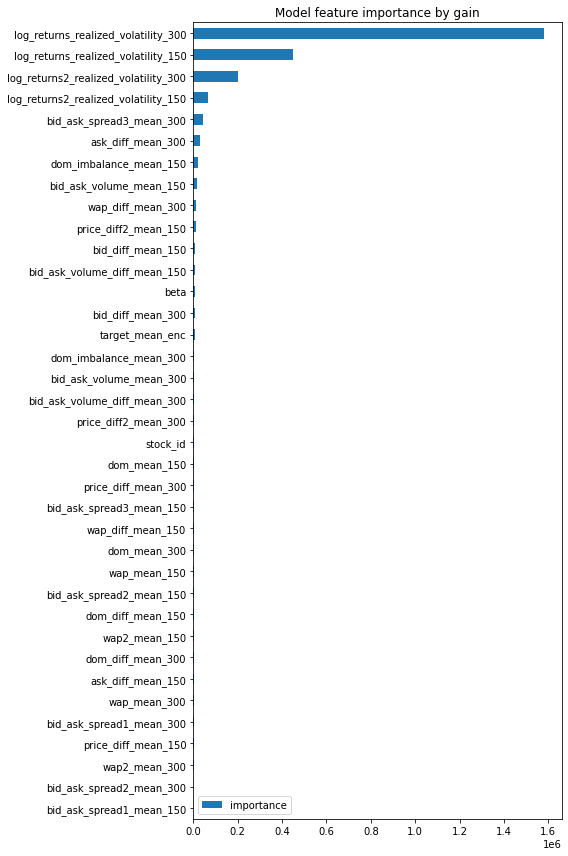

,feature_names,importance
0,bid_ask_spread1_mean_150,2.748520e+02
1,bid_ask_spread2_mean_300,4.274944e+02
2,wap2_mean_300,7.965170e+02
3,price_diff_mean_150,8.995935e+02
4,bid_ask_spread1_mean_300,9.721076e+02
5,wap_mean_300,1.278159e+03
6,ask_diff_mean_150,1.427568e+03
7,dom_diff_mean_300,1.545327e+03
8,wap2_mean_150,1.682712e+03
9,dom_diff_mean_150,2.027010e+03


In [16]:
import matplotlib

def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

mean_gain_df = calc_mean_importance(gain_importance_list)
plot_importance(mean_gain_df, title='Model feature importance by gain')
mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
mean_gain_df.to_csv('gain_importance_mean.csv', index=False)
    
mean_gain_df

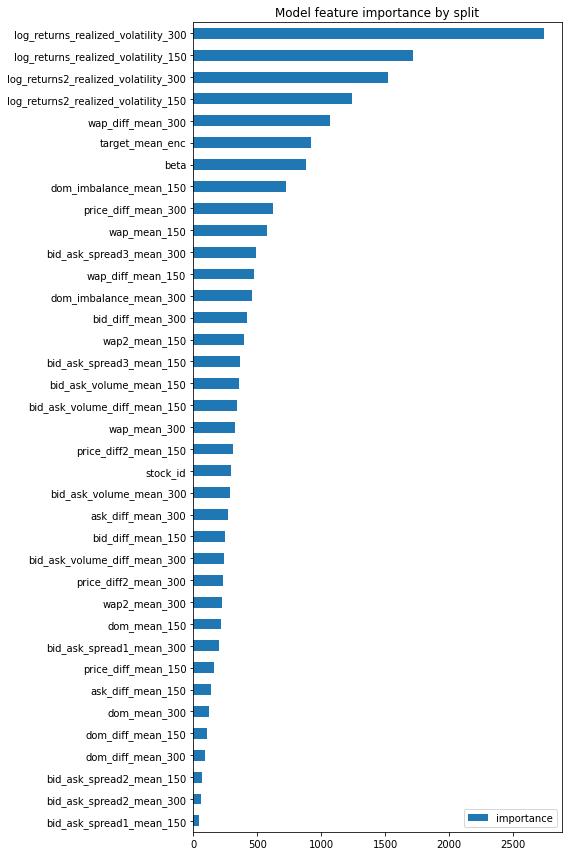

,feature_names,importance
0,bid_ask_spread1_mean_150,47.4
1,bid_ask_spread2_mean_300,57.0
2,bid_ask_spread2_mean_150,64.8
3,dom_diff_mean_300,89.0
4,dom_diff_mean_150,107.2
5,dom_mean_300,119.2
6,ask_diff_mean_150,136.0
7,price_diff_mean_150,161.6
8,bid_ask_spread1_mean_300,199.4
9,dom_mean_150,213.4


In [17]:
mean_split_df = calc_mean_importance(split_importance_list)
plot_importance(mean_split_df, title='Model feature importance by split')
mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
mean_split_df.to_csv('split_importance_mean.csv', index=False)

mean_split_df

## Test

In [18]:
y_test= df_test[['target_realized_volatility']]
X_test = df_test.drop(['time_id','target_realized_volatility'], axis = 1)

In [19]:
X_test

,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns2_realized_volatility_300,wap_diff_mean_300,price_diff_mean_300,price_diff2_mean_300,bid_diff_mean_300,ask_diff_mean_300,bid_ask_volume_mean_300,...,bid_ask_volume_diff_mean_150,dom_mean_150,dom_diff_mean_150,dom_imbalance_mean_150,bid_ask_spread1_mean_150,bid_ask_spread2_mean_150,bid_ask_spread3_mean_150,stock_id,beta,target_mean_enc
0,1.001625,1.001589,0.005063,0.004884,0.000286,0.000798,0.001052,0.000126,-0.000129,379.310000,...,243.066667,415.831269,243.600614,172.230655,0.000858,0.001083,0.000225,87,2.735538,0.003397
1,1.000864,1.000881,0.002954,0.003299,0.000385,0.000659,0.000930,0.000125,-0.000147,354.543333,...,141.426667,385.941573,141.606072,244.335501,0.000631,0.000883,0.000252,87,6.081658,0.003441
2,0.999580,0.999636,0.001820,0.002171,0.000134,0.000421,0.000670,0.000130,-0.000118,558.593333,...,215.153333,645.781327,214.963123,430.818204,0.000484,0.000735,0.000251,87,-2.366741,0.003417
3,1.000695,1.000617,0.002236,0.002573,0.000184,0.000634,0.000829,0.000089,-0.000106,518.850000,...,269.506667,413.239014,269.734520,143.504495,0.000650,0.000826,0.000176,87,4.314395,0.003416
4,0.998892,0.998688,0.001615,0.002326,0.000325,0.000614,0.000874,0.000144,-0.000116,631.673333,...,200.526667,629.278696,200.278030,429.000665,0.000519,0.000748,0.000228,87,4.541587,0.003403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94670,0.999751,0.999942,0.002284,0.004503,0.000464,0.000845,0.001202,0.000098,-0.000259,440.310000,...,142.680000,489.990053,142.497521,347.492532,0.000885,0.001238,0.000354,126,0.895436,0.003927
94671,1.001470,1.001513,0.002217,0.003652,0.000320,0.000680,0.000915,0.000132,-0.000102,255.356667,...,111.140000,208.004338,111.229365,96.774972,0.000734,0.000922,0.000187,126,-1.346971,0.003909
94672,1.000656,1.000586,0.001386,0.002686,0.000280,0.000817,0.001085,0.000091,-0.000177,349.626667,...,240.120000,316.138867,240.016389,76.122478,0.000844,0.001094,0.000250,126,0.904714,0.003915
94673,1.001787,1.001794,0.002783,0.004316,0.000269,0.000560,0.000853,0.000146,-0.000148,393.486667,...,158.993333,417.578664,159.297701,258.280963,0.000546,0.000847,0.000301,126,-0.099107,0.003894


In [20]:
y_test

,target_realized_volatility
0,0.005223
1,0.002043
2,0.001233
3,0.002295
4,0.000887
...,...
94670,0.002899
94671,0.003454
94672,0.002792
94673,0.002379


In [21]:
target = np.zeros(len(X_test))
scores = 0.0

# take mean of predictions for all models on test features 
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)

In [22]:
y_test = y_test.assign(predicted_volatility = target)
y_test

,target_realized_volatility,predicted_volatility
0,0.005223,0.003988
1,0.002043,0.002391
2,0.001233,0.001602
3,0.002295,0.001917
4,0.000887,0.001462
...,...,...
94670,0.002899,0.002139
94671,0.003454,0.002052
94672,0.002792,0.001492
94673,0.002379,0.002478


### Test Result

In [23]:
RMSPE = round(rmspe(y_true=y_test['target_realized_volatility'], y_pred=y_test['predicted_volatility']), 4)

print(f'Performance RMSPE: {RMSPE}')

Performance RMSPE: 0.257
